In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper,RankingWrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import visualize_population_curves_attacked,visualize_individual_curves_attacked,visualize_individual_curves_changes
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter,ExponentialFitter

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\torch_version.py:21: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=150
args.lr = 1e-3
args.batch_size= 512
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=100,length=10"
args.hidden_dims = [50,50]
args.pareto = [0.1,.9]
args.save_model = ""
args.dataset = "rott2"


In [4]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
# 3. Aids2
# 5. Framingham
# 6. rott2
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [5]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [6]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([2385, 18])

In [7]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))


# # model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(RightCensorWrapper(clf_robust),dataloader_train.dataset.tensors)
model_fragile_wrap = BoundedModule(RightCensorWrapper(clf_fragile),dataloader_train.dataset.tensors)

In [8]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=3666.5361 Time=0.0050
[ 1:   4]: eps=0.00000000 Loss=3256.1966 Time=0.0043
Epoch time: 0.0316, Total time: 0.0316
Evaluating...
[ 1:   1]: eps=0.00000000 Loss=2702.3401 Time=0.0013
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=3078.6758 Time=0.0040
[ 2:   4]: eps=0.00000000 Loss=2786.1131 Time=0.0038
Epoch time: 0.0300, Total time: 0.0616
Evaluating...
[ 2:   1]: eps=0.00000000 Loss=2312.6532 Time=0.0015
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=2618.6431 Time=0.0040
[ 3:   4]: eps=0.00000000 Loss=2376.5438 Time=0.0041
Epoch time: 0.0285, Total time: 0.0901
Evaluating...
[ 3:   1]: eps=0.00000000 Loss=1960.2615 Time=0.0015
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=2187.6797 Time=0.0050
[ 4:   4]: eps=0.00000000 Loss=1997.6582 Time=0.0046
Epoch time: 0.0300, Total time: 0.1200
Evaluating...
[ 4:   1]: eps=0.00000000 Loss=1638.9432 Time=0.0015
Epoch 5, learning rate [0.00

In [9]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=3666.5361 Time=0.0060
[ 1:   4]: eps=0.00000000 Loss=3256.1966 Time=0.0059
Epoch time: 0.0487, Total time: 0.0487
Evaluating...
[ 1:   1]: eps=0.00000000 Loss=2702.3401 Time=0.0032
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=3078.6758 Time=0.0070
[ 2:   4]: eps=0.00000000 Loss=2786.1131 Time=0.0066
Epoch time: 0.0689, Total time: 0.1176
Evaluating...
[ 2:   1]: eps=0.00000000 Loss=2312.6532 Time=0.0020
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=2618.6431 Time=0.0069
[ 3:   4]: eps=0.00000000 Loss=2376.5438 Time=0.0060
Epoch time: 0.0520, Total time: 0.1696
Evaluating...
[ 3:   1]: eps=0.00000000 Loss=1960.2615 Time=0.0025
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=2187.6797 Time=0.0040
[ 4:   4]: eps=0.00000000 Loss=1997.6582 Time=0.0048
Epoch time: 0.0479, Total time: 0.2175
Evaluating...
[ 4:   1]: eps=0.00000000 Loss=1638.9432 Time=0.0020
Epoch 5, learning rate [0.00

In [10]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)


In [11]:
clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 2385 total observations, 1368 right-censored observations>

<>:20: DeprecationWarning: invalid escape sequence '\l'
C:\Users\lpott\AppData\Local\Temp\ipykernel_5332\3948558937.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])


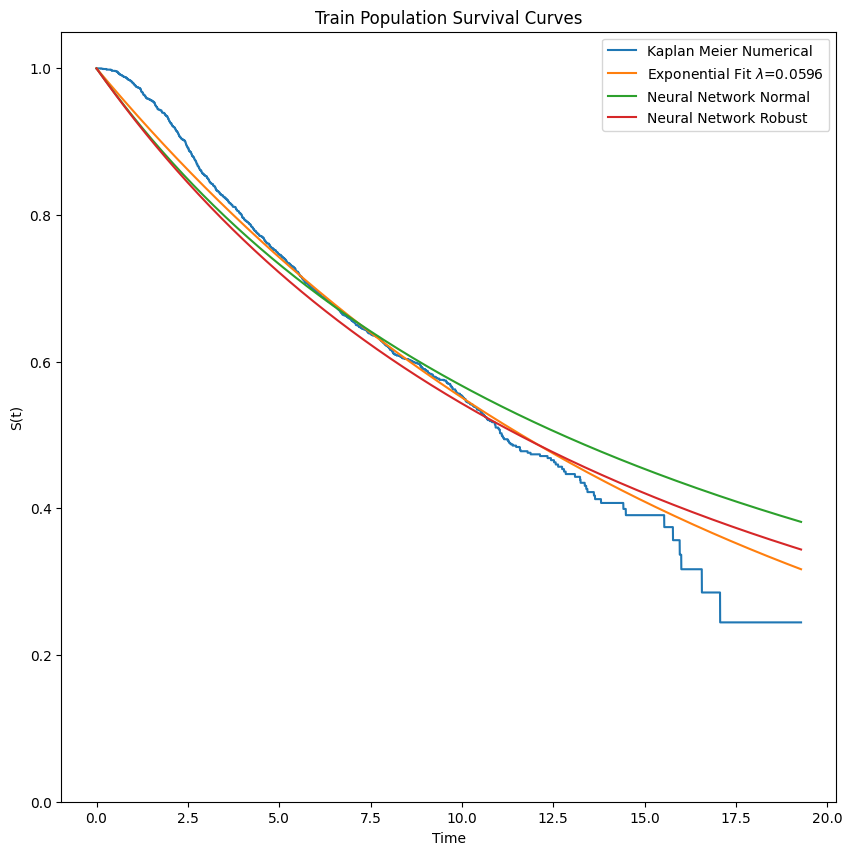

In [12]:

St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())
St_exp = clf_exp.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_exp)
plt.plot(t,St_fragile_x.mean(0))

plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.ylim([0,1.05])
plt.show()

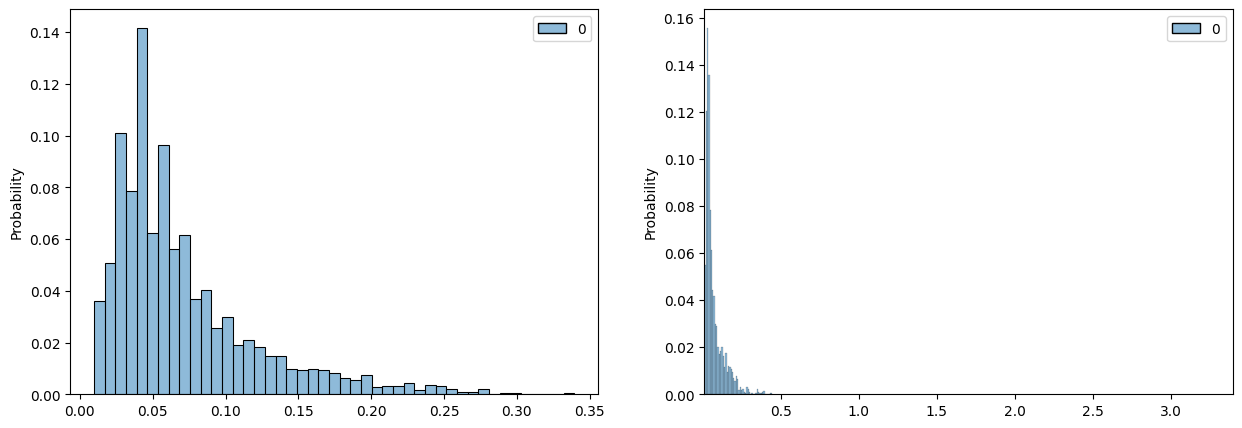

In [13]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
lambda_robust = clf_robust(X_train).detach()
lambda_fragile = clf_fragile(X_train).detach()
sns.histplot(lambda_robust,ax=axes[0],stat="probability")
axes[1].set_xlim([lambda_robust.min(),lambda_robust.max()*10])
sns.histplot(lambda_fragile,ax=axes[1],stat="probability")
plt.show()

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:444: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(


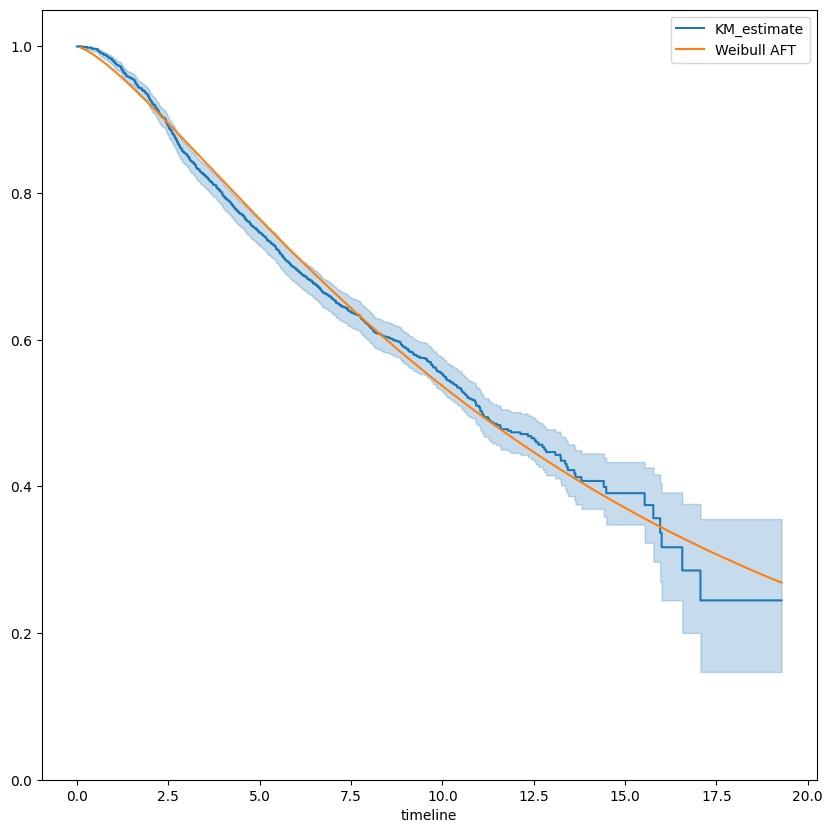

param    covariate           
lambda_  fac_chemo_yes          -0.009430
         fac_grade_3            -0.127138
         fac_hormon_yes         -0.012972
         fac_meno_pre            0.027316
         fac_recent_1988-1993   -0.002839
         fac_tsize_>20-50mmm    -0.145320
         fac_tsize_>50mm        -0.185068
         num_age                -0.126521
         num_estrogen           -0.000208
         num_nodes              -0.247991
         num_progesterone        0.086395
         num_year                0.026591
         Intercept               2.687479
rho_     Intercept               0.302076
dtype: float64


In [14]:
df_train,df_test = load_dataframe(ds_name=args.dataset,drop_first=True)
from lifelines import WeibullAFTFitter
clf_cph = WeibullAFTFitter()
clf_cph.fit(df=df_train,duration_col="time",event_col="event")
kmf.plot()
clf_cph.predict_survival_function(df_train).mean(1).plot(label="Weibull AFT",figsize=(10,10))
plt.legend()
plt.ylim([0,1.05])
plt.show()
print(clf_cph.params_)

In [15]:
print("Lifelines CPH Train CI: {:.3f}".format(clf_cph.score(df_train,scoring_method="concordance_index")))
print("Lifelines CPH Test CI: {:.3f}".format(clf_cph.score(df_test,scoring_method="concordance_index")))

# F_tr = 1-clf_exp.survival_function_at_times(times=T_train.ravel().numpy())
# exp_ci_tr = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())
# exp_ci_te = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())

# print("Lifelines EXP Train CI: {:.3f}".format(exp_ci_tr))
# print("Lifelines EXP Test CI: {:.3f}".format(exp_ci_te))

Lifelines CPH Train CI: 0.694
Lifelines CPH Test CI: 0.691


ROBUST CLF
CI @ eps=10 0.3493541371736733
CI @ eps=5 0.3537348397769715
CI @ eps=2 0.41423062786273157
CI @ eps=1 0.6290007788848455
CI @ eps=0.8 0.6737587759455896
CI @ eps=0.7 0.6851869173728496
CI @ eps=0.6 0.692441818980926
CI @ eps=0.5 0.6971915774906476
CI @ eps=0.1 0.7034661275032693
CI @ eps=0.07 0.7036034366869752
CI @ eps=0.05 0.7036430105128468
CI @ eps=0 0.7035992394630192
NONROBUST CLF
CI @ eps=10 0.3445171363660075
CI @ eps=5 0.34849670427978935
CI @ eps=2 0.38650046859007453
CI @ eps=1 0.5088264621779155
CI @ eps=0.8 0.5729606438301708
CI @ eps=0.7 0.6107314622108937
CI @ eps=0.6 0.6487924886480082
CI @ eps=0.5 0.6803694036764084
CI @ eps=0.1 0.7226378473277774
CI @ eps=0.07 0.7231960781139355
CI @ eps=0.05 0.7234988778421951
CI @ eps=0 0.72365417512857


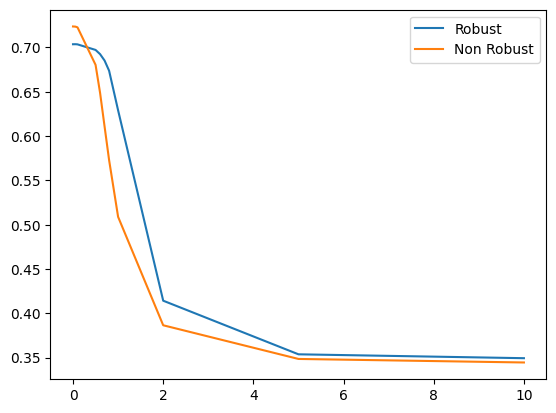

In [16]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_train,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_train,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

ROBUST CLF
CI @ eps=10 0.38118269844141256
CI @ eps=5 0.38197294132208587
CI @ eps=2 0.43554760023231237
CI @ eps=1 0.6258057145033371
CI @ eps=0.8 0.6523693004922356
CI @ eps=0.7 0.6580533366339462
CI @ eps=0.6 0.662299701992745
CI @ eps=0.5 0.6649274975959478
CI @ eps=0.1 0.6680789481200788
CI @ eps=0.07 0.6676600241833364
CI @ eps=0.05 0.6676124191905247
CI @ eps=0 0.6671458902609706
NONROBUST CLF
CI @ eps=10 0.3695527986975274
CI @ eps=5 0.38213479829764546
CI @ eps=2 0.4100503660823947
CI @ eps=1 0.5078024583218288
CI @ eps=0.8 0.5601679504146395
CI @ eps=0.7 0.5893593320067408
CI @ eps=0.6 0.6178366387066676
CI @ eps=0.5 0.6393255324618446
CI @ eps=0.1 0.6745817901381497
CI @ eps=0.07 0.6736011272862298
CI @ eps=0.05 0.6732964553322353
CI @ eps=0 0.6729822623796784


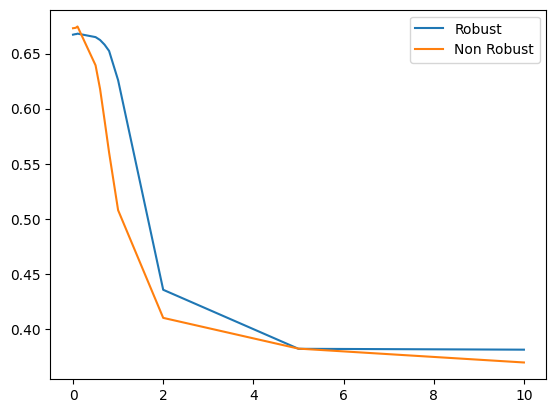

In [17]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_test,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_test,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

In [ ]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

In [ ]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="descending",test_cases=10)

In [ ]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="descending",test_cases=10)

In [ ]:
eps = 0.3
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="ascending",test_cases=10)

visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="ascending")